In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import pymc.sampling_jax
import xarray as xr
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
penguins = pd.read_csv("../data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape

(333, 8)

In [4]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [5]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


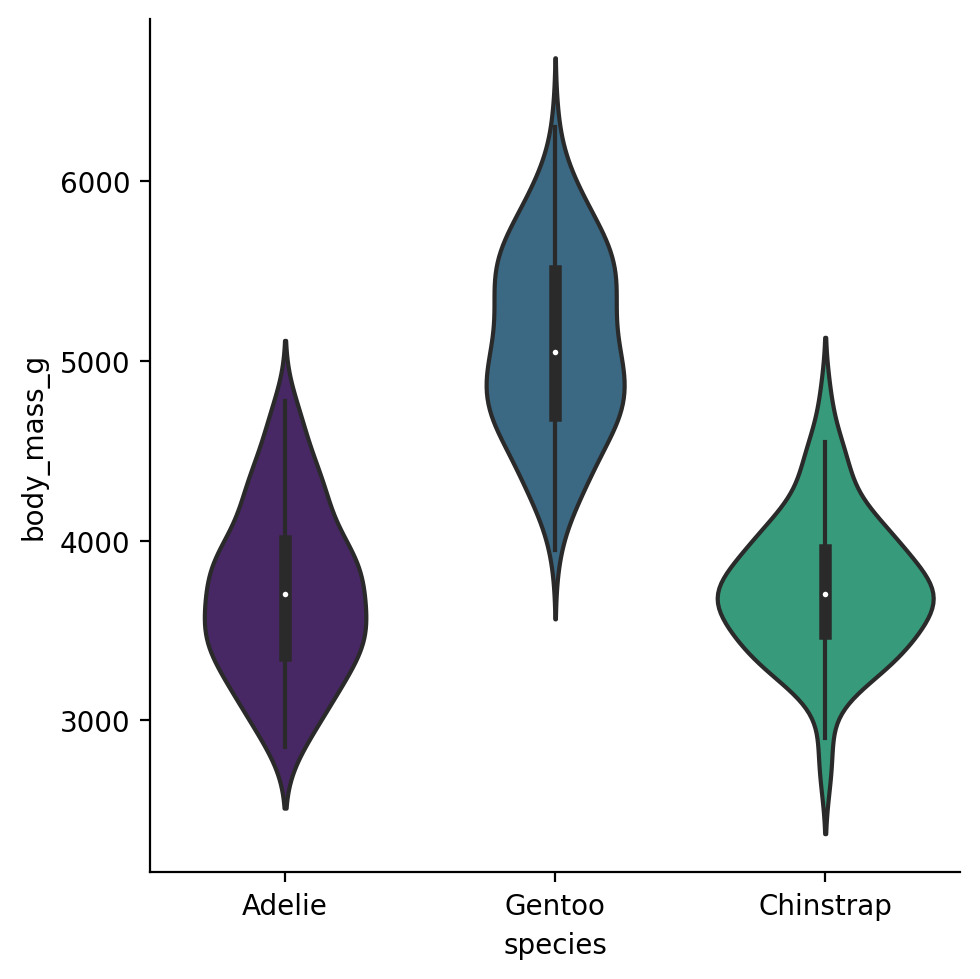

In [6]:
sns.catplot(kind="violin", data=penguins, x="species", y="body_mass_g")
plt.show()

In [7]:
[penguins["body_mass_g"].mean(), penguins["body_mass_g"].std()]

[4207.057057057057, 805.2158019428966]

In [8]:
coords = {"species": ["Adelie", "Gentoo", "Chinstrap"]}

with pm.Model(coords=coords) as model:
    # Constant data for species indices
    species_idx = pm.ConstantData(
        "species_idx",
        penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values,
    )

    # Normal priors for mu and sigma for each species
    mu = pm.Normal("mu", 4200, 1000, dims="species")
    sigma = pm.HalfNormal("sigma", 500, dims="species")

    # Likelihood
    y = pm.Normal(
        "y",
        mu=mu[species_idx],
        sigma=sigma[species_idx],
        observed=penguins["body_mass_g"],
    )

In [9]:
species_idx_values = (
    penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values
)
print(species_idx_values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


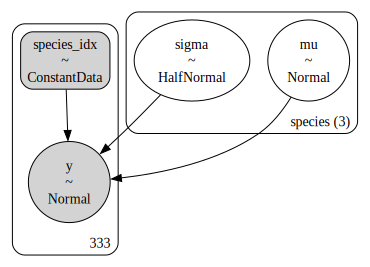

In [10]:
pm.model_to_graphviz(model)

In [11]:
with model:
    idata_prior = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [mu, sigma, y]


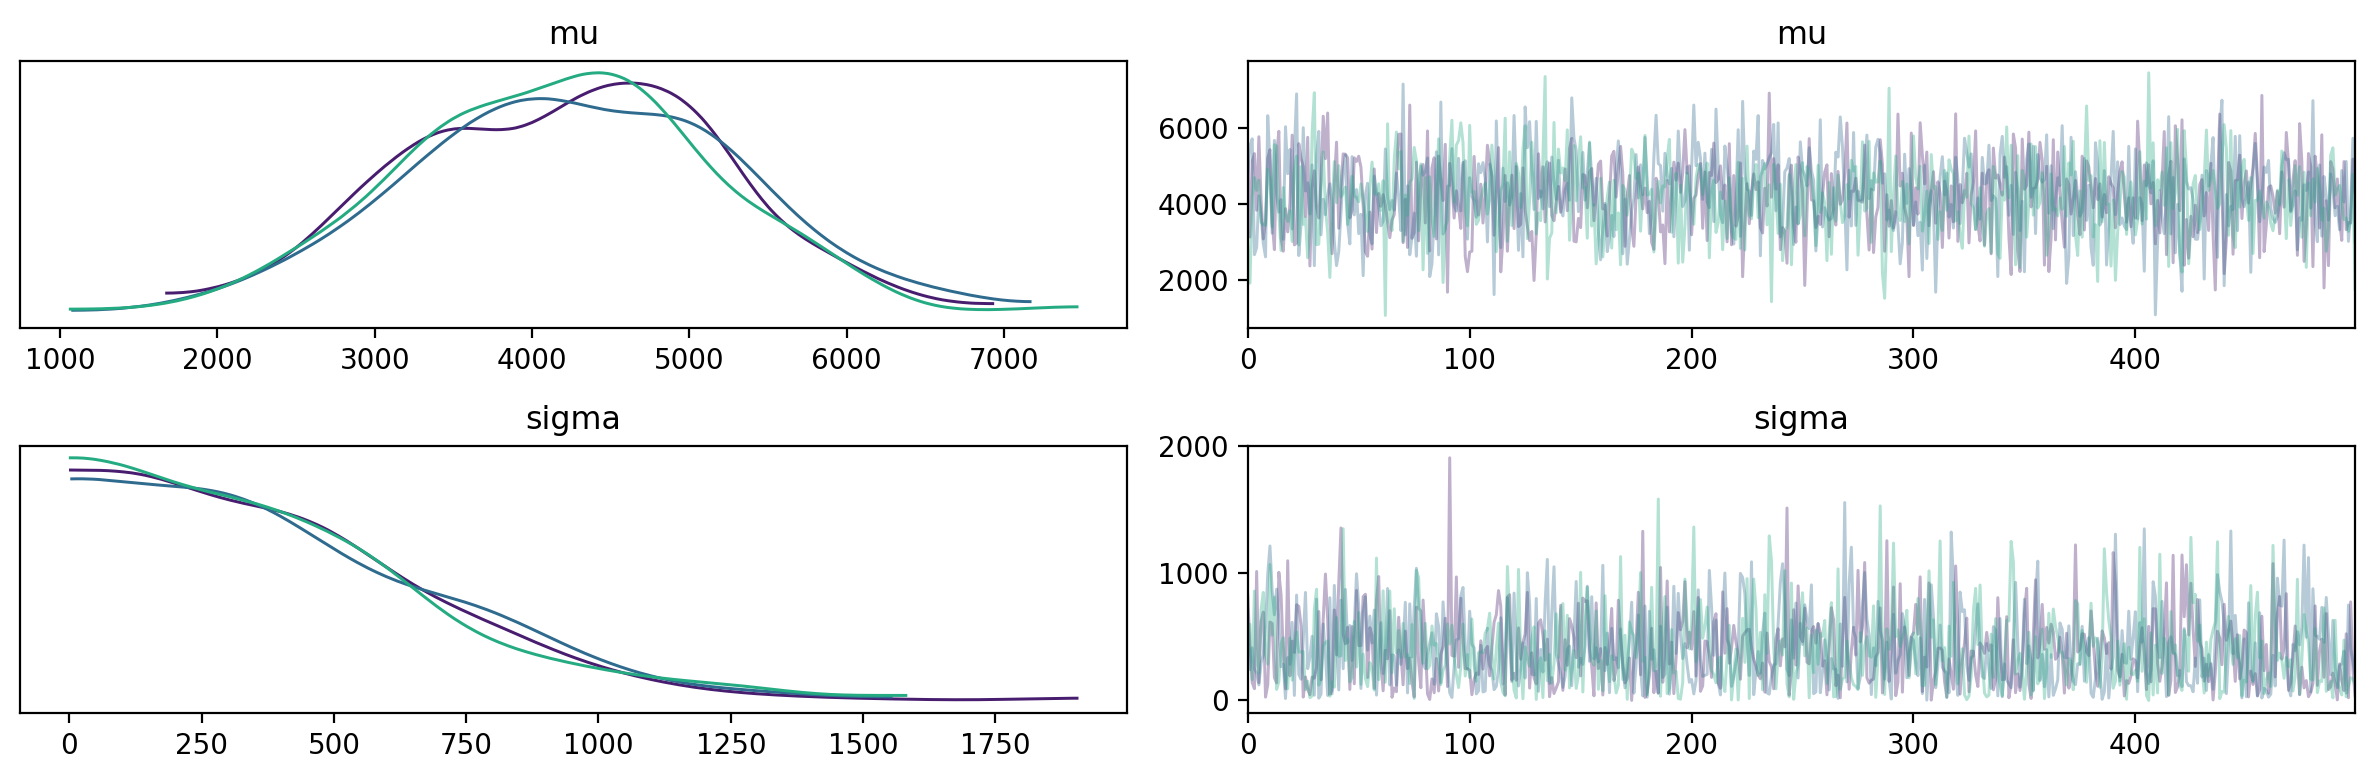

In [12]:
az.plot_trace(idata_prior.prior)
plt.tight_layout()
plt.show()

In [13]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:05.020748
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.970780
Transforming variables...
Transformation time =  0:00:00.016109
Computing Log Likelihood...


Log Likelihood time =  0:00:00.230840


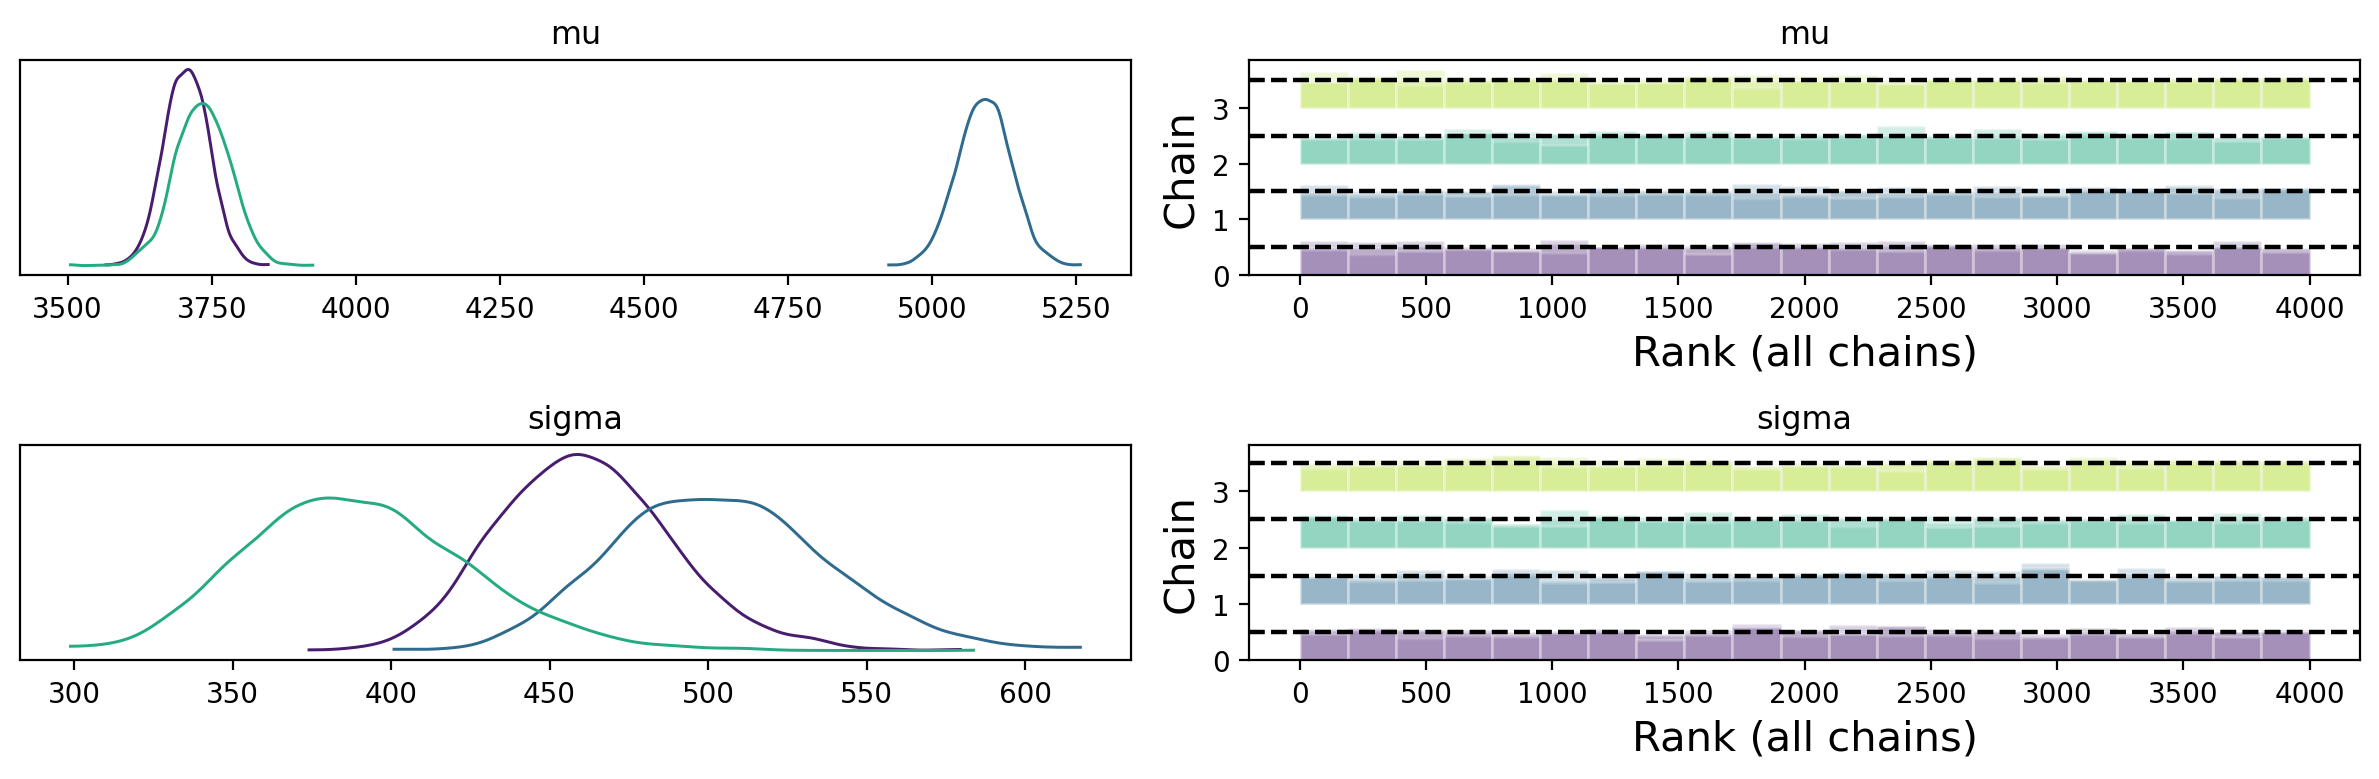

In [14]:
axes = az.plot_trace(idata, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

In [15]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[Adelie],3706.495,38.686,3633.977,3778.308,0.523,0.370,5474.0,2966.0,1.0
mu[Gentoo],5090.506,46.218,5004.136,5175.785,0.589,0.416,6167.0,3062.0,1.0
mu[Chinstrap],3734.168,47.785,3648.041,3827.145,0.666,0.471,5187.0,2950.0,1.0
sigma[Adelie],461.443,27.396,411.430,513.831,0.369,0.265,5786.0,3130.0,1.0
sigma[Gentoo],504.085,33.372,444.502,568.090,0.452,0.322,5473.0,3052.0,1.0
sigma[Chinstrap],390.069,34.926,326.310,453.333,0.485,0.353,5515.0,2980.0,1.0


In [16]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

In [17]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [18]:
mu_post = idata.posterior['mu']

In [19]:
mu_post.shape

(4, 1000, 3)

In [20]:
print(mu_post[:, :, 0].mean())

<xarray.DataArray 'mu' ()>
array(3706.49547541)
Coordinates:
    species  <U9 'Adelie'


In [21]:
np.array(
    [mu_post[:, :, 0].mean(), mu_post[:, :, 1].mean(), mu_post[:, :, 2].mean()]
).round(1)

array([3706.5, 5090.5, 3734.2])

In [22]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean"])
)
summary_stats.round(1)

,body_mass_g
,mean
species,
Adelie,3706.2
Chinstrap,3733.1
Gentoo,5092.4


In [23]:
sigma_post = idata.posterior["sigma"]
np.array(
    [sigma_post[:, :, 0].mean(), sigma_post[:, :, 1].mean(), sigma_post[:, :, 2].mean()]
).round(1)

array([461.4, 504.1, 390.1])

In [24]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 1]])

1.0

In [25]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 2]])

0.6705

In [26]:
np.mean([mu_post[:, :, 1] < mu_post[:, :, 2]])

0.0

In [27]:
np.mean([sigma_post[:, :, 0] < sigma_post[:, :, 2]])

0.05375

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.12.3

scipy     : 1.10.1
arviz     : 0.16.0
pymc      : 5.6.1
xarray    : 2023.6.0
pandas    : 2.0.3
seaborn   : 0.12.2
numpy     : 1.25.2
matplotlib: 3.7.2

Watermark: 2.4.3

